<a href="https://colab.research.google.com/github/JorgeTonatiuh/redes_basadas_atencion_tarea3/blob/main/Redes_basadas_en_atencion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes basadas en atención

Predicción de edades

Usa el conjunto de datos UTKFaces para entrenar y evalúar un modelo basado en la arquitectura ViT que prediga la edad de una persona dada la foto de su rostro, tratando la tarea como un problema de regresión. Agrega un bloque ResNet después de la capa convolucional que procesa los parches en ViT, entrena un modelo con la arquitectura modificada y compara su desempeño con ViT. Discute los resultados que obtuviste con las diferentes configuraciones.

## 1 Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
# Colab
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.1 Bibliotecas

In [2]:
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os
# marcas de tiempo
import datetime
# marcas de tiempo
import time
# gráficas
import matplotlib.pyplot as plt
# funciones aleatorias
import random
# csv
import pandas as pd
# sistema de archivos
from os.path import join
# sistema de archivos
from os.path import join
import math
import seaborn as sns

import torch
import torchvision
import PIL
from PIL import Image
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import numpy as np

torch.manual_seed(77)
np.random.seed(77)

# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import trange

# imágenes
from sklearn.model_selection import train_test_split

### 1.2. Auxiliares

In [3]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/faces'
filename = 'UTKFace.tar.gz'
data_dir = '../data/faces/UTKFace'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 128
# Corte al centro
IMG_CORP = 128
# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            ax[r, c].axis('off')
            i += 1
    fig.tight_layout()
    
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

def display_batch_net(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x

def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)

# reproducibilidad
set_seed()

## 2 Datos

### 2.2 Descarga de UTKFace

In [4]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

--2022-12-11 01:12:54--  https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.188.130.162
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.188.130.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106634631 (102M) [application/x-gzip]
Saving to: ‘../data/faces/UTKFace.tar.gz’

../data/faces/UTKFa 100%[===================>] 101.69M   697KB/s    in 2m 24s  

2022-12-11 01:15:19 (722 KB/s) - ‘../data/faces/UTKFace.tar.gz’ saved [106634631/106634631]



### 2.3 Conjunto de datos

Las etiquetas de cada imagen están definidas en el nombre del archivo, formateadas como: edad_genero_raza_fecha&tiempo.jpg

- Edad: es un entero entre 0 y 116, indica la edad.

- Genero: es 0 para hombre y 1 para mujer.

- Raza: es un entero de 0 a 4, denotando Blanco, Negro, Asiatico, Indu y Otro (como Hispano, Latino, Medio este).

- Fecha&Tiempo: esta en formato yyyymmddHHMMSSFFF, mostrando la fecha y tiempo en que la imagen fué recolectada a UTKFace.

In [5]:
! ls {data_dir} | head -5

100_0_0_20170112213500903.jpg.chip.jpg
100_0_0_20170112215240346.jpg.chip.jpg
10_0_0_20161220222308131.jpg.chip.jpg
10_0_0_20170103200329407.jpg.chip.jpg
10_0_0_20170103200522151.jpg.chip.jpg


Se construye un DataFrame con las rutas de los nombres de las imagenes y la edad 

In [6]:
img_names = sorted(os.listdir(data_dir))
df_data = {'name': img_names, 'age': [int(img.split('_')[0]) for img in img_names]}
df_data = pd.DataFrame(df_data)
df_data

,name,age
0,100_0_0_20170112213500903.jpg.chip.jpg,100
1,100_0_0_20170112215240346.jpg.chip.jpg,100
2,100_1_0_20170110183726390.jpg.chip.jpg,100
3,100_1_0_20170112213001988.jpg.chip.jpg,100
4,100_1_0_20170112213303693.jpg.chip.jpg,100
...,...,...
23703,9_1_3_20161220222856346.jpg.chip.jpg,9
23704,9_1_3_20170104222949455.jpg.chip.jpg,9
23705,9_1_4_20170103200637399.jpg.chip.jpg,9
23706,9_1_4_20170103200814791.jpg.chip.jpg,9


Se grafican los datos para observar la distribución de las diferentes edades.

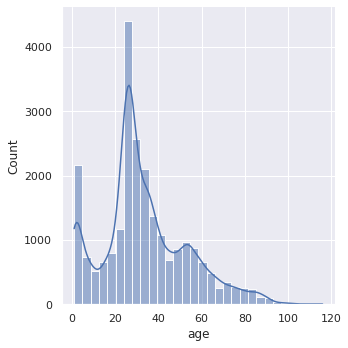

In [7]:
sns.set_theme()
sns.displot(df_data['age'],kde=True, bins=30)

In [8]:
print("Numero de ejemplos entre 24 y 28 años = ", len(df_data[(df_data['age'] >= 25) & (df_data['age'] <= 28)]))
print("Numero de ejemplos mayores a 80 años = ", len(df_data[(df_data['age'] >= 80)]))

Numero de ejemplos entre 24 y 28 años =  4464
Numero de ejemplos mayores a 80 años =  673


Se descartan edades con pocas muestras

In [9]:
samples = [df_data.iloc[i] for i in range(len(df_data)) if df_data['age'].iloc[i] >= 25 and df_data['age'].iloc[i] <= 28]
samples = pd.DataFrame(samples)
samples = samples.sample(frac=0.4)
df_data = df_data[(df_data['age']<25) | (df_data['age']>28)]
df_data = pd.concat([df_data,samples], ignore_index = True)
df_data = df_data[df_data['age']<80]

Dividimos  aleatoriamente el conjunto de datos en 80% para entrenamiento y 20% para prueba. Para eso usaremos la funcion `train_test_split` de scikit-learn, y se tomarán porcentages de los rangos de edades, para evitar que el conjunto de entrenamiento se quede sin una clase determinada o rango de edad determinado.

In [10]:
x_trn, y_trn = [], []
x_val, y_val = [], [] 

by_class = df_data.groupby('age')
for group, data in by_class:
  imgs = data['name'].values.tolist()
  ages = data['age'].values.tolist()
  x_tr, x_ts, y_tr, y_ts = train_test_split(imgs, ages, test_size=0.2, random_state=42)
  x_trn.extend(x_tr)
  y_trn.extend(y_tr)
  x_val.extend(x_ts)
  y_val.extend(y_ts)

A continuación se define una clase FacesDS para cargar las imaganes y las edades, dadas los nombres y rutas de las imagenes.

In [11]:
class FacesDS:

    def __init__(self, root, tsfm, subset):
          
        # validamos argumentos
        if subset not in {'trn', 'val'}:
            ValueError(f'invalid value for subset={subset}')
        
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm

        # nombre de imagenes
        names = []
        target = []
        if subset == 'trn':
          names = x_trn
          target = y_trn

        if subset == 'val':
          names = x_val
          target = y_val

        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        
        # por cada clase
        for i,name in enumerate(names):
            # directorio de la imagen
            img_dir = os.path.join(root, name)
            self.paths.append(img_dir)
            self.labels.append(target[i])
            
                

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta        
        y = np.array(self.labels[i], np.float32)#.reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

### 2.4 Exploración

Se realiza una exploración de los datos, para verificar que las imaganes son cargadas correctamente y también el shape de las imagenes.

x shape=torch.Size([32, 128, 128, 3]) dtype=torch.uint8
y shape=torch.Size([32]) dtype=torch.float32


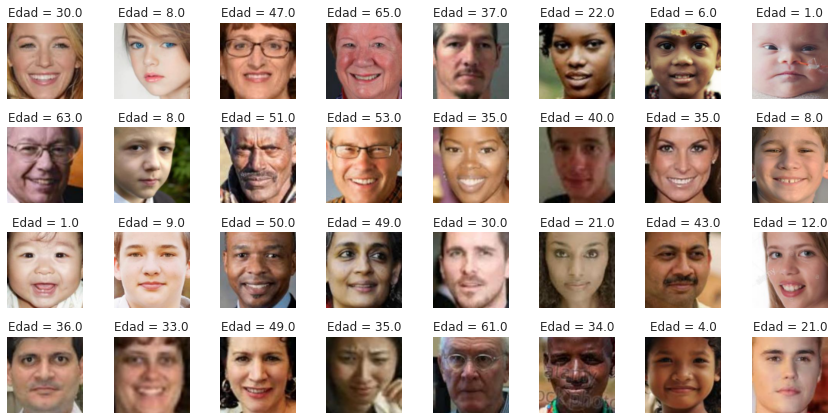

In [12]:
tsfm = transforms.Compose([
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # recortamos al centro a 210x210
    transforms.CenterCrop(IMG_CORP),
    # convertimos a ndarray
    np.array
])

ds = FacesDS(data_dir, tsfm, 'trn')

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_grid(x, titles, ROWS, COLS)

### 2.4 Cargador de datos

#### Entrenamiento

x shape=torch.Size([32, 3, 128, 128]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.float32


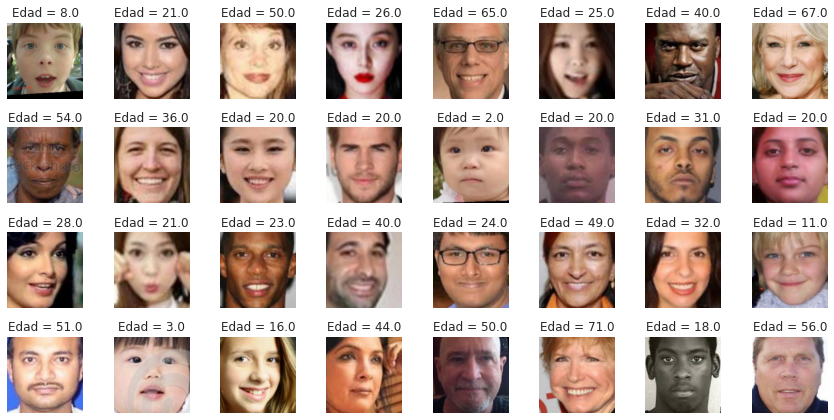

In [13]:
# transformación de entrenamiento
trn_tsfm = transforms.Compose([
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # cortamos al centro 224x224
    transforms.CenterCrop(IMG_CORP),
    # Agregar acrecentamiento de datos usando un espejeo horizontal.
    # aumentado de datos
    # espejeo horizontal aleatorio    
    transforms.RandomHorizontalFlip(),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor()
])

# conjunto
trn_ds = FacesDS(data_dir, trn_tsfm, 'trn')

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_batch(x, titles, ROWS, COLS)

In [14]:
train_batch, train_labels = next(iter(trn_dl))
train_batch.shape, train_labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

#### Validacion

x shape=torch.Size([32, 3, 128, 128]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.float32


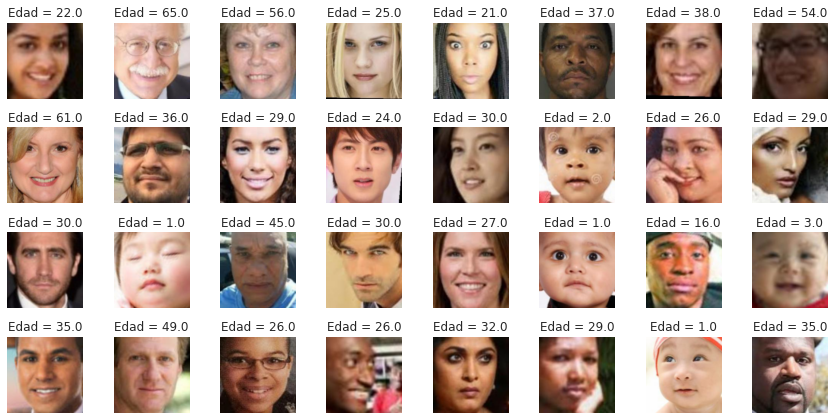

In [15]:
# transformación de entrenamiento
val_tsfm = transforms.Compose([
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # cortamos al centro 224x224
    transforms.CenterCrop(IMG_CORP),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor()
])

# conjunto
val_ds = FacesDS(data_dir, val_tsfm, 'val')

val_dl = DataLoader(
    # conjunto
    val_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(val_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_batch(x, titles, ROWS, COLS)

## 3.- Modelo ViT

In [16]:
import torchvision.transforms as T
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import torch.optim as optim
import time

- Definir auto atención producto punto

\begin{equation}
\mbox{MultiHead}(Q, K, V) = \text{Concat}(\mbox{head}_1,\mbox{head}_2,\ldots,\mbox{head}_h)W^O,
\end{equation}

\begin{equation}
\mbox{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) = \text{softmax}\left[\frac{QW_i^Q(KW_i^K)^T}{\sqrt{d_k}}\right]VW_i^V,
\end{equation}


In [17]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads, bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        self.qw = nn.Linear(dim, dim, bias = bias)
        self.kw = nn.Linear(dim, dim, bias = bias)
        self.vw = nn.Linear(dim, dim, bias = bias)

        self.ow = nn.Linear(dim, dim, bias = bias)

    def forward(self, x):
        q = self.qw(x)
        k = self.qw(x)
        v = self.qw(x)

        B, L, D = q.shape
        q = torch.reshape(q, [B, L, self.n_heads, -1])
        q = torch.permute(q, [0, 2, 1, 3])
        k = torch.reshape(k, [B, L, self.n_heads, -1])
        k = torch.permute(k, [0, 2, 3, 1])
        v = torch.reshape(v, [B, L, self.n_heads, -1])
        v = torch.permute(v, [0, 2, 1, 3])

        qk = torch.matmul(q, k) * self.scale
        attn = F.softmax(qk, dim=-1)
        v_attn = torch.matmul(attn, v)
        v_attn = torch.permute(v_attn, [0, 2, 1, 3])
        v_attn = torch.reshape(v_attn, [B, L, D])

        x = self.ow(v_attn)
        return x

test_layer = Attention(32, 2)
test_layer(torch.ones([1, 256, 32])).shape

torch.Size([1, 256, 32])

- Definir ViT:

\begin{align}
    \mathbb{h}_0 &= [ \mathbb{x}_\text{class}, \, \mathbb{x}_1 E, \ldots, \, \mathbb{x}_N E ] + E_{pos},
    &&  E_{pos}  \in \mathbb{R}^{(N + 1) \times D} \\
    \mathbb{h}^\prime_\ell &= \text{MSA}(\text{LN}(\mathbb{h}_{\ell-1})) + \mathbb{h}_{\ell-1}, && \ell=1,\ldots,L \\
    \mathbb{h}_\ell &= \text{MLP}(\text{LN}(\mathbb{h}^\prime_{\ell})) + \mathbb{h}^\prime_{\ell}, && \ell=1,\ldots,L   \\
    \mathbb{y} &= \text{LN}(\mathbb{h}_L^0)
\end{align}

In [18]:
class Transformer(nn.Module):
    def __init__(self, dim, heads, mlp_dim, rate=0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads)
        self.ln_2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(rate),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(rate),
        )

    def forward(self, x):
        x = self.attn(self.ln_1(x)) + x
        return self.mlp(self.ln_2(x)) + x

test_layer = Transformer(64, 2, 256)
test_layer(torch.ones([1, 64, 64])).shape

torch.Size([1, 64, 64])

In [19]:
summary(test_layer, (64, 64), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─LayerNorm: 1-1                         [-1, 64, 64]              128
├─Attention: 1-2                         [-1, 64, 64]              --
|    └─Linear: 2-1                       [-1, 64, 64]              4,160
|    └─Linear: 2-2                       [-1, 64, 64]              (recursive)
|    └─Linear: 2-3                       [-1, 64, 64]              (recursive)
|    └─Linear: 2-4                       [-1, 64, 64]              4,160
├─LayerNorm: 1-3                         [-1, 64, 64]              128
├─Sequential: 1-4                        [-1, 64, 64]              --
|    └─Linear: 2-5                       [-1, 64, 256]             16,640
|    └─GELU: 2-6                         [-1, 64, 256]             --
|    └─Dropout: 2-7                      [-1, 64, 256]             --
|    └─Linear: 2-8                       [-1, 64, 64]              16,448
|    └─Dropout: 2-9                      [-1, 64, 6

Layer (type:depth-idx)                   Output Shape              Param #
├─LayerNorm: 1-1                         [-1, 64, 64]              128
├─Attention: 1-2                         [-1, 64, 64]              --
|    └─Linear: 2-1                       [-1, 64, 64]              4,160
|    └─Linear: 2-2                       [-1, 64, 64]              (recursive)
|    └─Linear: 2-3                       [-1, 64, 64]              (recursive)
|    └─Linear: 2-4                       [-1, 64, 64]              4,160
├─LayerNorm: 1-3                         [-1, 64, 64]              128
├─Sequential: 1-4                        [-1, 64, 64]              --
|    └─Linear: 2-5                       [-1, 64, 256]             16,640
|    └─GELU: 2-6                         [-1, 64, 256]             --
|    └─Dropout: 2-7                      [-1, 64, 256]             --
|    └─Linear: 2-8                       [-1, 64, 64]              16,448
|    └─Dropout: 2-9                      [-1, 64, 6

In [20]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, out_dim, dim, 
                 depth, heads, mlp_dim, rate=0.0):
        super().__init__()
        self.dim = dim
        self.n_patches = (img_size // patch_size)**2
        
        self.patches = nn.Conv2d(3, dim, patch_size, 
                                 stride=patch_size, padding=0)

        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.transformer = nn.Sequential()
        for _ in range(depth):
            self.transformer.append(Transformer(dim, heads, mlp_dim))

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, out_dim),
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patches(x)

        x = torch.permute(x, [0, 2, 3, 1])
        x = torch.reshape(x, [B, self.n_patches, self.dim])

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embedding

        x = self.transformer(x)
        x = x[:, 0]
        return self.mlp_head(x)   


patch_size = 16
out_dim = 1
model_dim = 64
depth = 3
heads = 4
mlp_dim = 64
dropout = 0.5

vit = ViT(IMG_SIZE, patch_size, out_dim, 
          model_dim, depth, heads, mlp_dim, dropout)
test_out = vit(train_batch)
test_out.shape

torch.Size([32, 1])

In [21]:
summary(vit, (3, IMG_SIZE, IMG_SIZE), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 8, 8]            49,216
├─Sequential: 1-2                        [-1, 65, 64]              --
|    └─Transformer: 2-1                  [-1, 65, 64]              --
|    |    └─LayerNorm: 3-1               [-1, 65, 64]              128
|    |    └─Attention: 3-2               [-1, 65, 64]              16,640
|    |    └─LayerNorm: 3-3               [-1, 65, 64]              128
|    |    └─Sequential: 3-4              [-1, 65, 64]              8,320
|    └─Transformer: 2-2                  [-1, 65, 64]              --
|    |    └─LayerNorm: 3-5               [-1, 65, 64]              128
|    |    └─Attention: 3-6               [-1, 65, 64]              16,640
|    |    └─LayerNorm: 3-7               [-1, 65, 64]              128
|    |    └─Sequential: 3-8              [-1, 65, 64]              8,320
|    └─Transformer: 2-3                  [-1, 65, 64]          

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 8, 8]            49,216
├─Sequential: 1-2                        [-1, 65, 64]              --
|    └─Transformer: 2-1                  [-1, 65, 64]              --
|    |    └─LayerNorm: 3-1               [-1, 65, 64]              128
|    |    └─Attention: 3-2               [-1, 65, 64]              16,640
|    |    └─LayerNorm: 3-3               [-1, 65, 64]              128
|    |    └─Sequential: 3-4              [-1, 65, 64]              8,320
|    └─Transformer: 2-2                  [-1, 65, 64]              --
|    |    └─LayerNorm: 3-5               [-1, 65, 64]              128
|    |    └─Attention: 3-6               [-1, 65, 64]              16,640
|    |    └─LayerNorm: 3-7               [-1, 65, 64]              128
|    |    └─Sequential: 3-8              [-1, 65, 64]              8,320
|    └─Transformer: 2-3                  [-1, 65, 64]          

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [23]:
vit.to(device)

ViT(
  (patches): Conv2d(3, 64, kernel_size=(16, 16), stride=(16, 16))
  (transformer): Sequential(
    (0): Transformer(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qw): Linear(in_features=64, out_features=64, bias=True)
        (kw): Linear(in_features=64, out_features=64, bias=True)
        (vw): Linear(in_features=64, out_features=64, bias=True)
        (ow): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Transformer(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qw): Linear(in_features=64, out_featu

## 4.- Entrenamiento

In [24]:
optimizer = optim.Adam(vit.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [25]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    trn_loss = []
    for inputs, labels in train_loader:
        # data is a list of [inputs, labels]
        labels = labels.reshape(-1, 1).to(torch.float32)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        trn_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:4f} sec Train loss: {running_loss / len(train_loader):4f}')
    return np.mean(trn_loss)

In [26]:
def test(model, device, test_loader):
    start = time.time()
    running_loss = 0.0
    running_acc = 0.0
    val_loss = []
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            # data is a list of [inputs, labels]
            labels = labels.reshape(-1, 1).to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss.append(loss.item())

            outputs = torch.round(outputs)                                                

            running_acc += outputs.eq(labels.view_as(outputs)).sum().item()
            running_loss += loss.item()

    print(f'Time for eval is {time.time()-start:4f} sec Val loss: {running_loss / len(test_loader):4f}')
    print(f'Val acc: {running_acc / len(test_loader.dataset):4f}')
    return np.mean(val_loss)

In [27]:
epochs = 25

trn_loss_hist_vit, val_loss_hist_vit = [], []
for epoch in range(epochs):
    trn_loss_hist_vit.append(train(vit, device, trn_dl, optimizer, epoch))
    val_loss_hist_vit.append(test(vit, device, val_dl))

print('Finished Training')


Time for epoch 0 is 69.510625 sec Train loss: 543.736604
Time for eval is 11.204985 sec Val loss: 362.181005
Val acc: 0.032400

Time for epoch 1 is 69.167221 sec Train loss: 356.756911
Time for eval is 11.013834 sec Val loss: 357.845860
Val acc: 0.023143

Time for epoch 2 is 68.851750 sec Train loss: 343.007737
Time for eval is 11.120676 sec Val loss: 345.694995
Val acc: 0.028258

Time for epoch 3 is 70.899403 sec Train loss: 308.205850
Time for eval is 11.054134 sec Val loss: 274.568506
Val acc: 0.020706

Time for epoch 4 is 69.471973 sec Train loss: 247.134281
Time for eval is 11.037701 sec Val loss: 212.167033
Val acc: 0.029963

Time for epoch 5 is 69.483722 sec Train loss: 216.195876
Time for eval is 11.101618 sec Val loss: 216.732380
Val acc: 0.030938

Time for epoch 6 is 69.485566 sec Train loss: 199.790581
Time for eval is 11.112307 sec Val loss: 205.450213
Val acc: 0.039464

Time for epoch 7 is 69.696476 sec Train loss: 185.740899
Time for eval is 11.224995 sec Val loss: 173.2

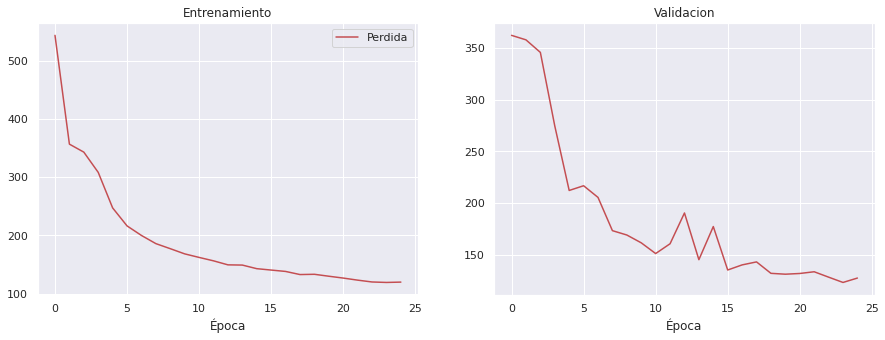

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(trn_loss_hist_vit, 'r', label='Perdida')
axs[0].title.set_text('Entrenamiento')
axs[0].set_xlabel(u'Época')
axs[0].legend()

axs[1].plot(val_loss_hist_vit, 'r', label='Perdida')
axs[1].title.set_text("Validacion")
axs[1].set_xlabel(u'Época')

plt.show()

## 4.1.- Predicciones del modelo

In [29]:
test_batch, test_labels = next(iter(val_dl))

In [30]:
device = torch.device('cpu')
vit.to(device)
vit.eval()
test_batch = test_batch.to(device)
pred = vit(test_batch)

In [31]:
pred = torch.round(pred).reshape(-1)
pred.shape, test_labels

(torch.Size([32]),
 tensor([ 1., 27., 56., 70., 36., 62., 14., 26., 65., 21., 76., 24., 35., 46.,
         35., 52., 29., 30., 26., 22., 23., 24.,  9., 58., 50., 47., 29., 18.,
         24.,  2., 63., 28.]))

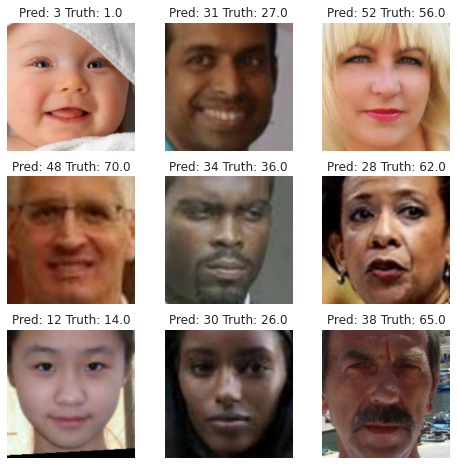

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.transpose(test_batch[i] * 255, [1, 2, 0]).numpy().astype("uint8"))    
    title = "Pred: {} Truth: {}".format(int(pred[i]),test_labels[i])
    plt.title(title)
    plt.axis("off")

## 5.- Modelo ViT con ResNet

In [33]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        out_channels1, out_channels2 = out_channels

        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
            # conv1
            # [N, I, H, W] => [N, O1, H, W
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels1, 
                      kernel_size=3, padding=1),
            # [N, O1, H, W]
            nn.BatchNorm2d(out_channels1),
            # [N, O1, H, W]
            nn.ReLU(),
            
            # conv2
            # [N, O1, H, W] => [N, O2, H, W]
            nn.Conv2d(in_channels=out_channels1, 
                      out_channels=out_channels2,
                      kernel_size=3, padding=1),
            # [N, O2, H, W]
            nn.BatchNorm2d(out_channels2),
            # [N, O2, H, W]
            nn.ReLU(),
        )

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, O2, H, W]
        x = x1 + x
        return x

In [34]:
class ViTM(nn.Module):
    def __init__(self, img_size, patch_size, out_dim, dim, 
                 depth, heads, mlp_dim, rate=0.0):
        super().__init__()
        self.dim = dim
        self.n_patches = (img_size // patch_size)**2
        
        self.patches = nn.Conv2d(3, dim, patch_size, 
                                 stride=patch_size, padding=0)
        
        self.resblock = ResBlock(dim, (dim,dim))

        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.transformer = nn.Sequential()
        for _ in range(depth):
            self.transformer.append(Transformer(dim, heads, mlp_dim))

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, out_dim),
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patches(x)
        x = self.resblock(x)

        x = torch.permute(x, [0, 2, 3, 1])
        x = torch.reshape(x, [B, self.n_patches, self.dim])

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embedding

        x = self.transformer(x)
        x = x[:, 0]
        return self.mlp_head(x)   


patch_size = 16
out_dim = 1
model_dim = 64
depth = 3
heads = 4
mlp_dim = 64
dropout = 0.5

vit_M = ViTM(IMG_SIZE, patch_size, out_dim, 
          model_dim, depth, heads, mlp_dim, dropout)
test_out = vit_M(train_batch)
test_out.shape

torch.Size([32, 1])

In [35]:
summary(vit_M, (3, IMG_SIZE, IMG_SIZE), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 8, 8]            49,216
├─ResBlock: 1-2                          [-1, 64, 8, 8]            --
|    └─Sequential: 2-1                   [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-1                  [-1, 64, 8, 8]            36,928
|    |    └─BatchNorm2d: 3-2             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-4                  [-1, 64, 8, 8]            36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-6                    [-1, 64, 8, 8]            --
├─Sequential: 1-3                        [-1, 65, 64]              --
|    └─Transformer: 2-2                  [-1, 65, 64]              --
|    |    └─LayerNorm: 3-7               [-1, 65, 64]              128
|    |    └─Attention: 3-8               [-1, 65, 64]              16,

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 8, 8]            49,216
├─ResBlock: 1-2                          [-1, 64, 8, 8]            --
|    └─Sequential: 2-1                   [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-1                  [-1, 64, 8, 8]            36,928
|    |    └─BatchNorm2d: 3-2             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-4                  [-1, 64, 8, 8]            36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-6                    [-1, 64, 8, 8]            --
├─Sequential: 1-3                        [-1, 65, 64]              --
|    └─Transformer: 2-2                  [-1, 65, 64]              --
|    |    └─LayerNorm: 3-7               [-1, 65, 64]              128
|    |    └─Attention: 3-8               [-1, 65, 64]              16,

In [36]:
vit_M.to(device)

ViTM(
  (patches): Conv2d(3, 64, kernel_size=(16, 16), stride=(16, 16))
  (resblock): ResBlock(
    (cnn_block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (transformer): Sequential(
    (0): Transformer(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qw): Linear(in_features=64, out_features=64, bias=True)
        (kw): Linear(in_features=64, out_features=64, bias=True)
        (vw): Linear(in_features=64, out_features=64, bias=True)
        (ow): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Se

## 5.1.- Entrenamiento

In [37]:
optimizer = optim.Adam(vit_M.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [38]:
epochs = 25

trn_loss_hist, val_loss_hist = [], []
for epoch in range(epochs):
    trn_loss_hist.append(train(vit_M, device, trn_dl, optimizer, epoch))
    val_loss_hist.append(test(vit_M, device, val_dl))

print('Finished Training')


Time for epoch 0 is 81.196392 sec Train loss: 530.804724
Time for eval is 12.045832 sec Val loss: 358.552305
Val acc: 0.009257

Time for epoch 1 is 83.262421 sec Train loss: 324.781729
Time for eval is 12.076530 sec Val loss: 241.047086
Val acc: 0.024604

Time for epoch 2 is 82.805317 sec Train loss: 205.903650
Time for eval is 12.080453 sec Val loss: 256.252719
Val acc: 0.020950

Time for epoch 3 is 82.021302 sec Train loss: 168.408442
Time for eval is 12.934094 sec Val loss: 163.192693
Val acc: 0.044823

Time for epoch 4 is 81.819278 sec Train loss: 149.050402
Time for eval is 12.113337 sec Val loss: 137.537212
Val acc: 0.048234

Time for epoch 5 is 82.974304 sec Train loss: 135.600752
Time for eval is 12.033327 sec Val loss: 139.027091
Val acc: 0.047016

Time for epoch 6 is 82.496536 sec Train loss: 126.159454
Time for eval is 11.963124 sec Val loss: 124.643234
Val acc: 0.064555

Time for epoch 7 is 81.705055 sec Train loss: 121.430193
Time for eval is 12.000574 sec Val loss: 120.1

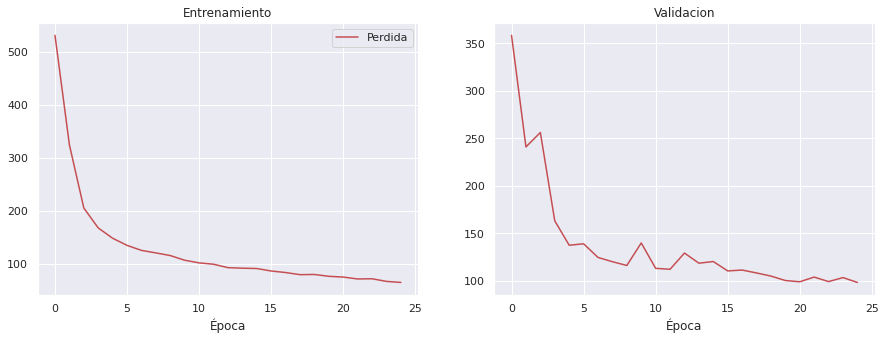

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(trn_loss_hist, 'r', label='Perdida')
axs[0].title.set_text('Entrenamiento')
axs[0].set_xlabel(u'Época')
axs[0].legend()

axs[1].plot(val_loss_hist, 'r', label='Perdida')
axs[1].title.set_text("Validacion")
axs[1].set_xlabel(u'Época')

plt.show()

## 5.2.- Predicciones del modelo

In [40]:
test_batch, test_labels = next(iter(val_dl))

In [41]:
device = torch.device('cpu')
vit_M.to(device)
vit_M.eval()
test_batch = test_batch.to(device)
pred = vit_M(test_batch)

In [42]:
pred = torch.round(pred).reshape(-1)
pred.shape, test_labels

(torch.Size([32]),
 tensor([25., 64., 35., 65., 60., 59., 70., 49.,  2., 45., 54., 75., 20., 32.,
         45.,  8., 24., 30., 29., 38.,  2., 20., 37., 32., 24.,  8., 54., 27.,
          7., 20., 56., 52.]))

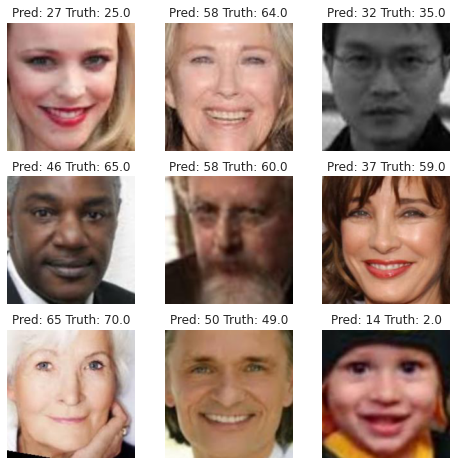

In [43]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.transpose(test_batch[i] * 255, [1, 2, 0]).numpy().astype("uint8"))    
    title = "Pred: {} Truth: {}".format(int(pred[i]),test_labels[i])
    plt.title(title)
    plt.axis("off")